<a href="https://colab.research.google.com/github/GurionRamapoguSajeevan/GenAI-customer-review-sentiment-engine/blob/main/GenAI_sentiment_engine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# STEP 1: LIBRARIES AND INITIAL SET UP

## Installing required Libraries

In [1]:
!pip install pandas nltk spacy scikit-learn transformers matplotlib seaborn streamlit
!python -m spacy download en_core_web_sm  # For English NLP preprocessing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 88.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 126.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 130.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


## Importing necessary libraries

In [1]:
import pandas as pd
import nltk
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from transformers import pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import streamlit as st
nltk.download('punkt')
nltk.download('stopwords')
nlp = spacy.load('en_core_web_sm')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# STEP 2: Loading Data set

In [2]:
df = pd.read_csv('/amazon_review.csv')

In [3]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",No issues.,4,Four Stars,1406073600,7/23/2014,138,0,0
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]","Purchased this for my device, it worked as adv...",5,MOAR SPACE!!!,1382659200,10/25/2013,409,0,0
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",it works as expected. I should have sprung for...,4,nothing to really say....,1356220800,12/23/2012,715,0,0
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",This think has worked out great.Had a diff. br...,5,Great buy at this price!!! *** UPDATE,1384992000,11/21/2013,382,0,0
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]","Bought it with Retail Packaging, arrived legit...",5,best deal around,1373673600,7/13/2013,513,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4915 entries, 0 to 4914
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   reviewerID      4915 non-null   object
 1   asin            4915 non-null   object
 2   reviewerName    4914 non-null   object
 3   helpful         4915 non-null   object
 4   reviewText      4914 non-null   object
 5   overall         4915 non-null   int64 
 6   summary         4915 non-null   object
 7   unixReviewTime  4915 non-null   int64 
 8   reviewTime      4915 non-null   object
 9   day_diff        4915 non-null   int64 
 10  helpful_yes     4915 non-null   int64 
 11  total_vote      4915 non-null   int64 
dtypes: int64(5), object(7)
memory usage: 460.9+ KB


### Relevant columns: We'll focus on reviewText (for text analysis), overall (rating, as a proxy for sentiment validation), and asin (product ID, for filtering in the dashboard).

In [5]:
df = df[['reviewText', 'overall', 'asin']]
df.head()

,reviewText,overall,asin
0,No issues.,4,B007WTAJTO
1,"Purchased this for my device, it worked as adv...",5,B007WTAJTO
2,it works as expected. I should have sprung for...,4,B007WTAJTO
3,This think has worked out great.Had a diff. br...,5,B007WTAJTO
4,"Bought it with Retail Packaging, arrived legit...",5,B007WTAJTO


# Step 3: Cleaning and Preprocessing the Text

In [7]:
# Here I am defining a preprocessing function (this handles lowercase, tokenization, stopword removal, and lemmatization—standard NLP steps to make text ready for models):

In [6]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    if pd.isna(text):
        return ''
    text = text.lower()  # Lowercase
    tokens = word_tokenize(text)  # Tokenize
    tokens = [word for word in tokens if word.isalnum() and word not in stop_words]  # Remove stopwords and non-alphanumeric
    doc = nlp(' '.join(tokens))  # Lemmatize with spaCy
    lemmatized = [token.lemma_ for token in doc]
    return ' '.join(lemmatized)

### this extra one is needed for the tabular data in the tokenizer. 'punkt_tab' tokenizer model required for word_tokenize in recent NLTK versions

In [10]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [11]:
# Applying the Preprocessing Function to the reviewText column:

In [12]:
df['cleaned_review'] = df['reviewText'].apply(preprocess_text)
df.head()

,reviewText,overall,asin,cleaned_review
0,No issues.,4,B007WTAJTO,issue
1,"Purchased this for my device, it worked as adv...",5,B007WTAJTO,purchase device work advertise never much phon...
2,it works as expected. I should have sprung for...,4,B007WTAJTO,work expect sprung high capacity think make bi...
3,This think has worked out great.Had a diff. br...,5,B007WTAJTO,think work diff bran 64 gb card go south 3 one...
4,"Bought it with Retail Packaging, arrived legit...",5,B007WTAJTO,buy retail packaging arrive legit orange envel...


In [14]:
# Dropping empty reviews if any

In [15]:
df = df.dropna(subset=['cleaned_review'])

# Step 4: Extract Insights Using NLP and AI Models

###  1. Sentiment Analysis (using a lightweight DistilBERT model)

In [19]:
sentiment_pipeline = pipeline('sentiment-analysis', model='distilbert-base-uncased-finetuned-sst-2-english', device=0)  # device=0 uses GPU

# df['sentiment'] = df['cleaned_review'].apply(lambda x: sentiment_pipeline(x)[0]['label'] if x else 'NEUTRAL')

Device set to use cuda:0


In [20]:
df['sentiment'] = df['cleaned_review'].apply(lambda x: sentiment_pipeline(x, truncation=True, max_length=512)[0]['label'] if x else 'NEUTRAL')

In [22]:
df.head(20)

,reviewText,overall,asin,cleaned_review,sentiment
0,No issues.,4,B007WTAJTO,issue,NEGATIVE
1,"Purchased this for my device, it worked as adv...",5,B007WTAJTO,purchase device work advertise never much phon...,NEGATIVE
2,it works as expected. I should have sprung for...,4,B007WTAJTO,work expect sprung high capacity think make bi...,NEGATIVE
3,This think has worked out great.Had a diff. br...,5,B007WTAJTO,think work diff bran 64 gb card go south 3 one...,POSITIVE
4,"Bought it with Retail Packaging, arrived legit...",5,B007WTAJTO,buy retail packaging arrive legit orange envel...,NEGATIVE
5,It's mini storage. It doesn't do anything els...,5,B007WTAJTO,mini storage anything else suppose purchase ad...,NEGATIVE
6,I have it in my phone and it never skips a bea...,5,B007WTAJTO,phone never skip beat file transfer speedy cor...,NEGATIVE
7,It's hard to believe how affordable digital ha...,5,B007WTAJTO,hard believe affordable digital become 32 gb d...,NEGATIVE
8,Works in a HTC Rezound. Was running short of ...,5,B007WTAJTO,work htc rezound run short space 64 gb sandisk...,NEGATIVE
9,"in my galaxy s4, super fast card, and am total...",5,B007WTAJTO,galaxy s4 super fast card totally happy happy ...,POSITIVE


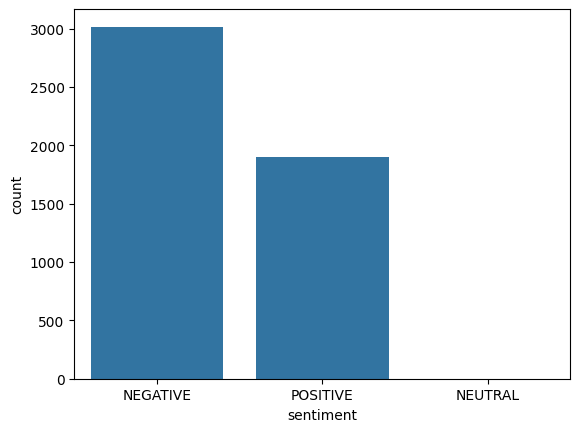

In [23]:
sns.countplot(x='sentiment', data=df)
plt.show()  # Quick viz in notebook

### 2. Themes/Topics (using traditional LDA for simplicity and to show hybrid skills—AI + classic ML):

In [24]:
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(df['cleaned_review'])

lda = LatentDirichletAllocation(n_components=5, random_state=42)  # Extract 5 main themes
lda.fit(dtm)

# Display top words per theme (print in notebook)
for i, topic in enumerate(lda.components_):
    print(f"Theme {i}: {' '.join([vectorizer.get_feature_names_out()[index] for index in topic.argsort()[-10:]])}")

# Assign dominant theme to each review
df['theme'] = lda.transform(dtm).argmax(axis=1)

Theme 0: read write 10 sandisk 32 class speed 64 gb card
Theme 1: product note great phone samsung buy sandisk card galaxy work
Theme 2: price fast memory buy use 34 sandisk sd good card
Theme 3: good memory price gopro video great camera use work card
Theme 4: galaxy memory tablet storage great music use work phone card


### 3. Pain Points and Suggestions (using zero-shot classification with BART—another HuggingFace model, GPU-accelerated):

In [25]:
zero_shot_pipeline = pipeline('zero-shot-classification', model='facebook/bart-large-mnli', device=0)  # GPU

pain_labels = ['quality issue', 'delivery problem', 'price complaint', 'usability issue', 'no pain']
suggestion_labels = ['improve durability', 'better packaging', 'add features', 'lower price', 'no suggestion']

def extract_pain_point(text):
    if not text:
        return 'none'
    result = zero_shot_pipeline(text, candidate_labels=pain_labels)
    return result['labels'][0]

def extract_suggestion(text):
    if not text:
        return 'none'
    result = zero_shot_pipeline(text, candidate_labels=suggestion_labels)
    return result['labels'][0]

df['pain_point'] = df['cleaned_review'].apply(extract_pain_point)
df['suggestion'] = df['cleaned_review'].apply(extract_suggestion)

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cuda:0


In [26]:
df.to_csv('/processed_reviews.csv', index=False)